In [1]:
import os

# 1) ENV VARS – before any TF import
os.environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/usr/local/cuda-12.3"
os.environ["CUDA_HOME"] = "/usr/local/cuda-12.3"

# 2) Sanity check
print("XLA_FLAGS:",    os.environ["XLA_FLAGS"])
print("Looking here:", os.path.exists(
    "/usr/local/cuda-12.3/nvvm/libdevice/libdevice.10.bc"
))


XLA_FLAGS: --xla_gpu_cuda_data_dir=/usr/local/cuda-12.3
Looking here: True


In [2]:
import sys

sys.path.insert(0, "/tmp/torch_pkg")
import torch
print("Torch version:", torch.__version__)

sys.path.insert(0, "/tmp/accelerate")
import accelerate
print("Accelerate version:", accelerate.__version__)

Torch version: 2.7.0+cu126
Accelerate version: 1.6.0


/home/smpandit/.conda/envs/sentimentAnalysisENV/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sys.path.insert(0, "/tmp/wandb_pkg")
import wandb
print("wandb version:", wandb.__version__)

# point caches and matplotlib to /tmp 
os.environ['XDG_CACHE_HOME'] = '/tmp'
os.environ['TRANSFORMERS_CACHE'] = '/tmp/transformers'
os.environ['HF_HOME'] = '/tmp/huggingface_cache'
os.environ['MPLCONFIGDIR'] = '/tmp/.matplotlib'

# suppress TF INFO logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

wandb version: 0.19.10


In [4]:
os.environ["MPLCONFIGDIR"] = "/tmp/matplotlib"
# suppress TF INFO logs
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime
import psutil
import subprocess
import GPUtil


import tensorflow as tf
import torch 
#import tf_keras as keras
from torch.utils.data import TensorDataset
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.losses  import BinaryCrossentropy
from transformers import create_optimizer
from transformers import(
    AutoConfig, 
    AutoTokenizer, 
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)

# Enable script imports
sys.path.append(os.path.abspath(".."))


from scripts.result_logger import log_results
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    #precision_score, recall_score, f1_score, 
    classification_report, confusion_matrix
)

import wandb.integration.keras as wbk
print(dir(wbk))
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint, WandbEvalCallback
print("wandb version:", wandb.__version__)
print("wandb package path:", wandb.__file__)


2025-05-08 14:40:48.981345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746740449.004188 3547874 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746740449.010864 3547874 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746740449.028443 3547874 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746740449.028474 3547874 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746740449.028477 3547874 computation_placer.cc:177] computation placer alr

['WandbCallback', 'WandbEvalCallback', 'WandbMetricsLogger', 'WandbModelCheckpoint', '__all__', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'callbacks', 'keras']
wandb version: 0.19.10
wandb package path: /tmp/wandb_pkg/wandb/__init__.py


In [6]:
# GPU setup
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    raise RuntimeError("No GPU found.")
tf.config.experimental.set_memory_growth(gpus[0], True)
print("GPU ready:", gpus[0])


GPU ready: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


# BERT

## Data Preprocessing 

In [ ]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
MAX_SEQ_LEN = 100

# Data Loading & Label Binarization 
def load_splits():
    X_train = pd.read_csv("../data/splits/X_train.csv")["clean_text"].tolist()
    X_val   = pd.read_csv("../data/splits/X_val.csv")["clean_text"].tolist()
    X_test  = pd.read_csv("../data/splits/X_test.csv")["clean_text"].tolist()

    y_train = pd.read_csv("../data/splits/y_train.csv")["sentiment_label"].map(lambda x: 1 if x=="Positive" else 0).tolist()
    y_val   = pd.read_csv("../data/splits/y_val.csv")["sentiment_label"].map(lambda x: 1 if x=="Positive" else 0).tolist()
    y_test  = pd.read_csv("../data/splits/y_test.csv")["sentiment_label"].map(lambda x: 1 if x=="Positive" else 0).tolist()

    return X_train, y_train, X_val, y_val, X_test, y_test



In [8]:
#  Best hyperparameters from sweep ()
BEST_CONFIG = {
    "model": "prajjwal1/bert-tiny",
    "dataset": "Sentiment140",
    'batch_size': 64,
    'learning_rate': 3e-5,
    'dropout': 0.2,
    'epochs': 5,
    'weight_decay': 0.01,
    'warmup_ratio': 0.1,
    'optimizer': "adam",
    'max_seq_len': 100,
    'metric_goal':"maximize",
    'metric_name':"val_accuracy",
    'model_type':"BERT",
}

## Model Training

In [9]:
# W&B Initialization

wandb.init(
    project="sentiment-analysis",
    name="BERT_Social",
    config=BEST_CONFIG
)
#model_name = "prajjwal1/bert-tiny"
cfg = wandb.config

wandb: Currently logged in as: smpandit (smpandit-) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [10]:
# tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(cfg.model)

config = AutoConfig.from_pretrained(
    cfg.model,
    num_labels=2,
    hidden_dropout_prob=cfg.get("dropout", 0.1),
    attention_probs_dropout_prob=cfg.get("dropout", 0.1),
)

model = AutoModelForSequenceClassification.from_pretrained(cfg.model, config=config)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at prajjwal1/bert-tiny and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Prepare Dataset 
X_train, y_train, X_val, y_val, X_test, y_test = load_splits()

# Define tiny dataset wrapper:
class HFDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels    = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            "input_ids":      self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels":         self.labels[idx],
        }

# Create dict‐style datasets:
enc_train = tokenizer(
    X_train, truncation=True, padding="max_length",
    max_length=cfg.max_seq_len, return_tensors="pt"
)
train_dataset = HFDataset(enc_train, torch.tensor(y_train, dtype=torch.long))

enc_val = tokenizer(
    X_val, truncation=True, padding="max_length",
    max_length=cfg.max_seq_len, return_tensors="pt"
)
val_dataset = HFDataset(enc_val, torch.tensor(y_val, dtype=torch.long))

enc_test = tokenizer(
    X_test, truncation=True, padding="max_length",
    max_length=cfg.max_seq_len, return_tensors="pt"
)
test_dataset = HFDataset(enc_test, torch.tensor(y_test, dtype=torch.long))


In [12]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    acc   = accuracy_score(labels, preds)
    prec, rec, f1, _ = precision_recall_fscore_support(labels, preds, average="binary")
    
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

In [ ]:
start_tuning = time.time()

training_args = TrainingArguments(
    output_dir="./wandb_bert_pt",
    per_device_train_batch_size=cfg.batch_size,
    per_device_eval_batch_size=cfg.batch_size,
    learning_rate=cfg.learning_rate,
    weight_decay=cfg.weight_decay,
    warmup_ratio=cfg.warmup_ratio,
    num_train_epochs=cfg.epochs,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    save_strategy="no",
    report_to="wandb",
)
tuning_time = time.time() - start_tuning

/home/smpandit/.conda/envs/sentimentAnalysisENV/lib/python3.10/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [14]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer),
    compute_metrics=compute_metrics,
)

/tmp/ipykernel_1648342/320371002.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [15]:
# Training 
start_training = time.time() 

trainer.train()

training_time = time.time() - start_training

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.517000,0.429680,0.802073,0.809420,0.790023,0.799604
2,0.437500,0.418243,0.808480,0.806021,0.812325,0.809160
3,0.423800,0.410667,0.812460,0.818943,0.802131,0.810450
4,0.416400,0.410498,0.813692,0.832427,0.785353,0.808205
5,0.412600,0.409623,0.814577,0.825687,0.797360,0.811276


In [16]:
val_metrics = trainer.evaluate(eval_dataset=val_dataset)

print("---- Validation metrics ----")
print(f"Accuracy:  {val_metrics['eval_accuracy']}")
print(f"Precision: {val_metrics['eval_precision']}")
print(f"Recall:    {val_metrics['eval_recall']}")
print(f"F1:        {val_metrics['eval_f1']}")

---- Validation metrics ----
Accuracy:  0.8145772253823473
Precision: 0.8256874383511863
Recall:    0.7973596256684492
F1:        0.8112763226130055


In [17]:
test_predictions = trainer.predict(test_dataset)

test_metrics = test_predictions.metrics

print("\n---- Test metrics ----")
print(f"Accuracy:  {test_metrics['test_accuracy']}")
print(f"Precision: {test_metrics['test_precision']}")
print(f"Recall:    {test_metrics['test_recall']}")
print(f"F1:        {test_metrics['test_f1']}")


---- Test metrics ----
Accuracy:  0.8138820895397699
Precision: 0.8254226859514875
Recall:    0.7959886344643156
F1:        0.8104384968496466


In [18]:
start_inf = time.time()
preds_output = trainer.predict(test_dataset)    
total_inf = time.time() - start_inf

infer_time = total_inf / len(preds_output.predictions)

In [19]:
# System Stats

cpu_usage = psutil.cpu_percent(interval=1)
mem_usage = psutil.virtual_memory().percent
gpu = GPUtil.getGPUs()[0]
power = float(subprocess.check_output(
    ["nvidia-smi","--query-gpu=power.draw","--format=csv,noheader,nounits"]
))

In [20]:
# turn logits to class table
y_pred = np.argmax(preds_output.predictions, axis=1)
y_true = preds_output.label_ids

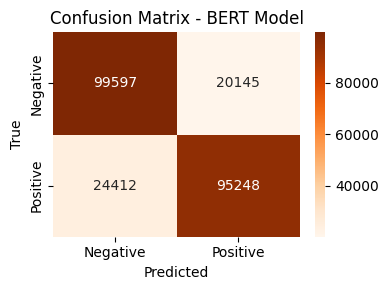

In [21]:
# Confusion Matrix

cm = confusion_matrix(y_true, y_pred, labels=[0,1])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt="d", cmap="Oranges", xticklabels=["Negative","Positive"], yticklabels=["Negative","Positive"])
plt.title("Confusion Matrix - BERT Model")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.savefig("bert_confusion_matrix.png")

In [22]:
# Logging results 

log_results(
    model_name=cfg.model_type,
    dataset_name="Social Media",

    accuracy=test_metrics["test_accuracy"],
    precision=test_metrics["test_precision"],
    recall=test_metrics["test_recall"],
    f1=test_metrics["test_f1"],

    tuning_time=tuning_time,
    train_time=training_time,
    inference_time=infer_time,
    latency=infer_time*1000,

    cpu_usage=cpu_usage,
    mem_usage=mem_usage,
    gpu_usage=gpu.load*100,
    gpu_mem_usage=gpu.memoryUtil*100,
    gpu_temp=gpu.temperature,
    power=power,
    
    hyperparams=f"batch={cfg.batch_size}, epochs={cfg.epochs}, dropout={cfg.dropout}, learning_rate={cfg.learning_rate}, weight_decay={cfg.weight_decay}, warmup_ratio={cfg.warmup_ratio}, optimizer={cfg.optimizer}, " 
)

wandb.log({
    "Validation Accuracy": val_metrics["eval_accuracy"], 
    "Validation Precision": val_metrics["eval_precision"],
    "Validation Recall": val_metrics["eval_recall"], 
    "Validation F1 Score": val_metrics["eval_f1"],

    "Test Accuracy": test_metrics["test_accuracy"],
    "Test Precision": test_metrics["test_precision"],
    "Test Recall": test_metrics["test_recall"],
    "Test F1 Score": test_metrics["test_f1"],

    "Tuning Time (s)": tuning_time,             
    "Training Time (s)": training_time,
    "Inference Time per Sample (s)": infer_time,
    "Latency (ms)": infer_time * 1000,

    "CPU Usage (%)": cpu_usage,
    "Memory Usage (%)": mem_usage,
    "GPU Usage (%)": gpu.load * 100,
    "GPU Memory Usage (%)": gpu.memoryUtil * 100,
    "GPU Temp (C)": gpu.temperature,
    "Power Consumption (W)": float(power), 

    "max_len": 100,
    "Confusion Matrix": wandb.Image("bert_confusion_matrix.png")
})

wandb.finish()


Logged: bert on Social Media to ../results/results.csv


/research2/smpandit/Sentiment_Analysis_ML_DL_LLM/scripts/result_logger.py:41: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, row_df], ignore_index=True)


CPU Usage (%),▁
GPU Memory Usage (%),▁
GPU Temp (C),▁
GPU Usage (%),▁
Inference Time per Sample (s),▁
Latency (ms),▁
Memory Usage (%),▁
Power Consumption (W),▁
Test Accuracy,▁
Test F1 Score,▁
Test Precision,▁
